<a href="https://colab.research.google.com/github/MominAhmedShaikh/Artificial-neural-netwrok-ANN-/blob/main/ANN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies and importing libraries

In [157]:
!pip install -U keras-tuner -q
!pip install -U imblearn -q
!pip install -U scikeras -q

In [158]:
# Use scikit-learn to grid search the batch size and epochs
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import layers
from keras import regularizers
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models
import keras_tuner
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,recall_score

In [159]:
tf.random.set_seed(1)

# Defining functions

#### Data processing functions

In [160]:
def count_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return len(df_in)-len(df_out)

#### Model building functions

In [161]:
def build_model(hp):
    model = keras.Sequential()
    units=hp.Int("input nuerons", min_value=1, max_value=100, step=1)
    activation=hp.Choice("activation", ["relu", "tanh"])
    model.add(Dense(units = units, input_shape=(34,), activation=activation)) # input 

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=1, max_value=100, step=5),  # 1 hidden 
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=['accuracy'] ###
    )
    return model

In [162]:
def model_training(model,x_train,y_train,x_test,y_test):
    
    model.compile(optimizer='adam'
                  , loss='binary_crossentropy'
                  , metrics=accuracy)
    
    history = model.fit(x_train
                       , y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , validation_data=(x_test, y_test)
                       , verbose=0
                       , callbacks = callback
        )
    
    predictions = model.predict(x_test[0:])
    
    y_pred = []
    for i in predictions:
        if i > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
            
    y = y_test[0:]
    
    
    ConfusionMatrixDisplay(confusion_matrix(y,y_pred)).plot()
    plt.show()
    print(classification_report(y,y_pred,zero_division=0))
    print('ROC_AUC_score:',roc_auc_score(y,y_pred))
    print('Accuracy:',accuracy_score(y,y_pred))
    print('Precision_score:',precision_score(y,y_pred))
    print('Recall_score:',recall_score(y,y_pred))

    
    return history

In [163]:
# def history(model):
#     '''
#     Function to train a multi-class model. The number of epochs and 
#     batch_size are set by the constants at the top of the
#     notebook. 
    
#     Parameters:
#         model : model with the chosen architecture
#         X_train : training features
#         y_train : training target
#         X_valid : validation features
#         Y_valid : validation target
#     Output:
#         model training history
#     '''
#     model.compile(optimizer='adam'
#                   , loss='binary_crossentropy'
#                   , metrics=accuracy)
    
#     history = model.fit(x_train
#                        , y_train
#                        , epochs=epochs
#                        , batch_size=batch_size
#                        , validation_data=(x_test, y_test)
#                        , verbose=0 
#                        , callbacks = callback)
#     return history

#### Model evaluation functions

In [164]:
# def eval_metric(model, history, metric_name):
#     '''
#     Function to evaluate a trained model on a chosen metric. 
#     Training and validation metric are plotted in a
#     line chart for each epoch.
    
#     Parameters:
#         history : model training history
#         metric_name : loss or accuracy
#     Output:
#         line chart with epochs of x-axis and metric on
#         y-axis
#     '''
#     metric = history.history[metric_name]
#     val_metric = history.history['val_' + metric_name]

#     e = range(1, epochs + 1)

#     plt.plot(e, metric, 'bo', label='Train ' + metric_name)
#     plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
#     plt.xlabel('Epoch number')
#     plt.ylabel(metric_name)
#     plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
#     plt.legend()
#     plt.show()

In [165]:
# def test_model(model,x_train,y_train,x_test,y_test):
#     '''
#     Function to test the model on new data after training it
#     on the full training data with the optimal number of epochs.
    
#     Parameters:
#         model : trained model
#         X_train : training features
#         y_train : training target
#         X_test : test features
#         y_test : test target
#         epochs : optimal number of epochs
#     Output:
#         test accuracy and test loss
#     '''
#     try:
#         model.fit(x = x_train
#                   , y = y_train
#                   , epochs=epochs
#                   , batch_size=batch_size
#                   , verbose=0 
#                   , callbacks = callback)
#         results = model.evaluate(x_test, y_test)
#     except Warning as e:
#         print(e)
#     else:
#         print('Test accuracy: {0:.2f}%'.format(results[1]*100))
#         print('Test loss: {0:.2f}%'.format(results[0]*100))

In [166]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model

    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

#### Model loss / Accuracy viz functions

In [217]:
from traitlets.traitlets import MetaHasDescriptors
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]

    e = len(metric_model_1)
    f = len(metric_model_2)
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss',
        'val_binary_accuracy' : 'Binary accuracy'
    }
    
    metric_label = metrics_dict[metric]

    plt.plot([i for i in range(len(metric_model_1))], metric_model_1, 'b-', label=model_1.name,color = 'blue')
    plt.plot([i for i in range(len(metric_model_2))], metric_model_2, 'b', label=model_2.name,color = 'red')
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [168]:
def plot(model,model_history,title,metric):
    df = pd.DataFrame(model_history.history)
    plt.figure(figsize=(20, 5))
    plt.suptitle(title,fontsize = 20)
    plt.subplot(1, 2, 1)
    
    plt.plot(df[metric],color = 'blue')
    plt.plot(df['val_'+ metric],color = 'red')
    plt.xlabel('# of epochs')
    plt.ylabel('acc metrics')
    plt.legend(['train_accuracy','test_accuracy'])
    
    plt.subplot(1, 2, 2)
    
    plt.plot(df['loss'],color = 'blue')
    plt.plot(df['val_loss'],color = 'red')
    plt.xlabel('# of epochs')
    plt.ylabel('loss metrics')
    plt.legend(['train_loss','test_loss'])
    plt.show()

    
    results = model.evaluate(x_test, y_test)
    return results

# Data preprocessing

### Data reading

#### Hr dataset with outliers and imbalanced classes

In [169]:
hr_ds1 = pd.read_csv('/content/HR Interview Analytics.csv') # without removing outliers

In [170]:
# Seperating all columns with data type object storing in object_features list.
object_features = []

for feature_name in hr_ds1.columns:
    if hr_ds1[feature_name].dtype == 'O':
        object_features.append(feature_name)
        
object_features

['DOJ.Extended',
 'Offered.band',
 'Joining.Bonus',
 'Candidate.relocate.actual',
 'Gender',
 'Candidate.Source',
 'LOB',
 'Location']

In [171]:
hr_ds1.drop(columns=['SLNO','Candidate.Ref'],inplace=True)
hr_ds1.drop_duplicates(inplace = True)

In [172]:
# Label encoding all columns with 0 and 1 as unique values

for feature_name in object_features:
    if hr_ds1[feature_name].nunique() == 2:
        le = LabelEncoder()
        hr_ds1[feature_name] = le.fit_transform(hr_ds1[feature_name])

In [173]:
# One hot encoding all categorical columns with more than 1 unique values

object_features_ = []

for feature_name in hr_ds1.columns:
    if hr_ds1[feature_name].dtype == 'O' and hr_ds1[feature_name].nunique() > 2:
        object_features_.append(feature_name)
        
object_features_

['Offered.band', 'Candidate.Source', 'LOB', 'Location']

In [174]:
hr_ds1 = pd.get_dummies(data=hr_ds1 , columns = object_features_ , drop_first=True)

In [175]:
# Splitting the dataset into train and test
x = hr_ds1.drop(columns=['Status'])
y = hr_ds1[['Status']]

In [176]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.80,random_state=42)

In [177]:
# Scaling X_train and X_test
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.fit_transform(x_test)

#### Comment Hr_ds2 if you want to use hr_ds1 or vice versa using (Clt + /) 

#### HR dataset without outliers and balanced classes

In [178]:
hr_ds2 = pd.read_csv('/content/HR Interview Analytics.csv') # with removing outliers

In [179]:
# Seperating all columns with data type object storing in object_features list.
object_features = []

for feature_name in hr_ds2.columns:
    if hr_ds2[feature_name].dtype == 'O':
        object_features.append(feature_name)
        
object_features

['DOJ.Extended',
 'Offered.band',
 'Joining.Bonus',
 'Candidate.relocate.actual',
 'Gender',
 'Candidate.Source',
 'LOB',
 'Location']

In [180]:
hr_ds2.drop(columns=['SLNO','Candidate.Ref'],inplace=True)
hr_ds2.drop_duplicates(inplace = True)

In [181]:
num_col1 = ['Age','Notice.period','Rex.in.Yrs','Duration.to.accept.offer','Pecent.hike.expected.in.CTC','Percent.hike.offered.in.CTC','Percent.difference.CTC'] 
for i in num_col1:
    print(i,'-', count_outlier(hr_ds2,i))

Age - 28
Notice.period - 42
Rex.in.Yrs - 196
Duration.to.accept.offer - 408
Pecent.hike.expected.in.CTC - 500
Percent.hike.offered.in.CTC - 641
Percent.difference.CTC - 1200


In [182]:
#Removing outliers
for i in num_col1:
    q1 = hr_ds2[i].quantile(0.25)
    q3 = hr_ds2[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    hr_ds2 = hr_ds2[(hr_ds2[i] > fence_low) & (hr_ds2[i] < fence_high)]

In [183]:
hr_ds2.shape

(6627, 16)

In [184]:
# Label encoding all columns with object data which was stored in object_features

for feature_name in object_features:
    if hr_ds2[feature_name].nunique() == 2:
        le = LabelEncoder()
        hr_ds2[feature_name] = le.fit_transform(hr_ds2[feature_name])

In [185]:
# One hot encoding all categorical columns with more than 1 unique values

object_features_ = []

for feature_name in hr_ds2.columns:
    if hr_ds2[feature_name].dtype == 'O' and hr_ds2[feature_name].nunique() > 2:
        object_features_.append(feature_name)
        
object_features_

['Offered.band', 'Candidate.Source', 'LOB', 'Location']

In [186]:
hr_ds2 = pd.get_dummies(data=hr_ds2 , columns = object_features_ , drop_first=True)

In [187]:
hr_ds2.shape

(6627, 35)

In [188]:
x = hr_ds2.drop(columns=['Status'])
y = hr_ds2[['Status']]

In [189]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.80,random_state=42)

In [190]:
# Scaling X_train and X_test
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [191]:
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_test, y_test = sm.fit_resample(x_test, y_test)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((8660, 34), (8660, 1), (2136, 34), (2136, 1))

# Model building

#### pre-defined variables

In [192]:
callback = callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
epochs = 100
accuracy = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)
batch_size = 20

### Base model

In [193]:
base_model = models.Sequential()
base_model.add(layers.Dense(11, activation='relu', input_shape=(34,)))
base_model.add(layers.Dense(4, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))
base_model._name = 'Baseline_model'
base_model.summary()

Model: "Baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 11)                385       
                                                                 
 dense_8 (Dense)             (None, 4)                 48        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 438
Trainable params: 438
Non-trainable params: 0
_________________________________________________________________


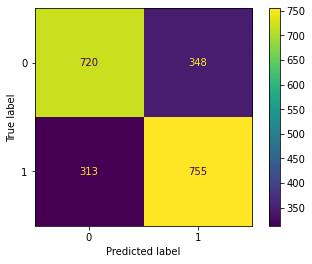

              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1068
           1       0.68      0.71      0.70      1068

    accuracy                           0.69      2136
   macro avg       0.69      0.69      0.69      2136
weighted avg       0.69      0.69      0.69      2136

ROC_AUC_score: 0.6905430711610487
Accuracy: 0.6905430711610487
Precision_score: 0.6844968268359021
Recall_score: 0.7069288389513109


In [194]:
base_model_history = model_training(base_model,x_train,y_train,x_test,y_test)

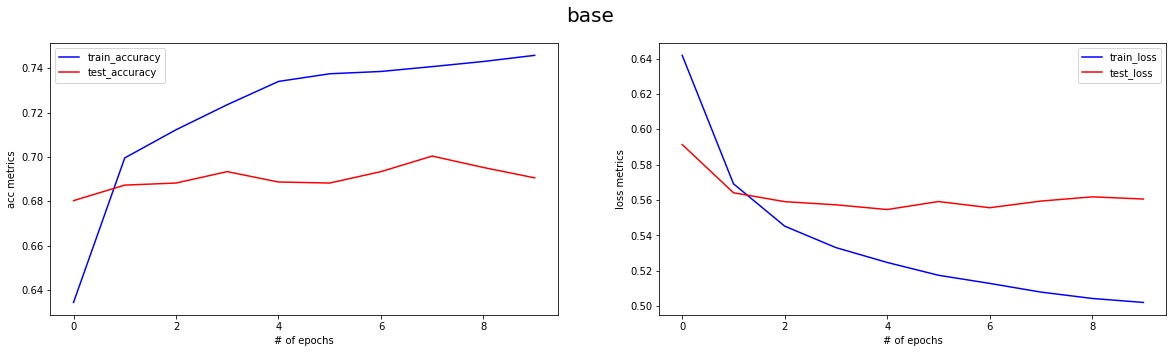

67/67 [==============================] - 0s 924us/step - loss: 0.5606 - binary_accuracy: 0.6905


[0.5605510473251343, 0.6905430555343628]

In [195]:
plot(base_model,history,'base','binary_accuracy')

### Our model

#### Neurons reduced model

In [196]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(8, activation='relu', input_shape=(34,)))
reduced_model.add(layers.Dense(1, activation='sigmoid'))
reduced_model._name = 'Reduced_model'
reduced_model.summary()

Model: "Reduced_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 280       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


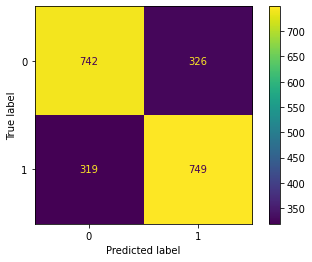

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      1068
           1       0.70      0.70      0.70      1068

    accuracy                           0.70      2136
   macro avg       0.70      0.70      0.70      2136
weighted avg       0.70      0.70      0.70      2136

ROC_AUC_score: 0.6980337078651686
Accuracy: 0.6980337078651685
Precision_score: 0.6967441860465117
Recall_score: 0.701310861423221


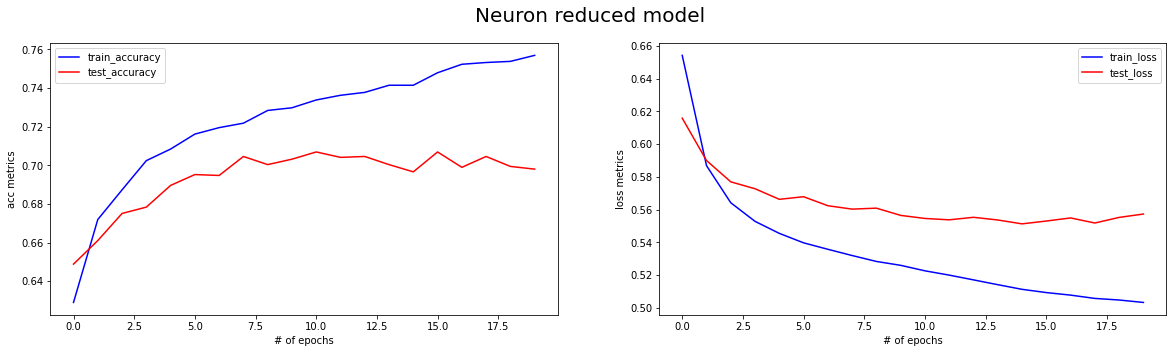

67/67 [==============================] - 0s 939us/step - loss: 0.5574 - binary_accuracy: 0.6980


[0.5573598742485046, 0.6980336904525757]

In [197]:
reduced_model_history = model_training(reduced_model,x_train,y_train,x_test,y_test)
plot(reduced_model,reduced_model_history,'Neuron reduced model','binary_accuracy')

#### Regularization model

In [198]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(11, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(34,)))
reg_model.add(layers.Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(1, activation='sigmoid'))
reg_model._name = 'L2_Regularization_model'
reg_model.summary()

Model: "L2_Regularization_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 11)                385       
                                                                 
 dense_13 (Dense)            (None, 4)                 48        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 438
Trainable params: 438
Non-trainable params: 0
_________________________________________________________________


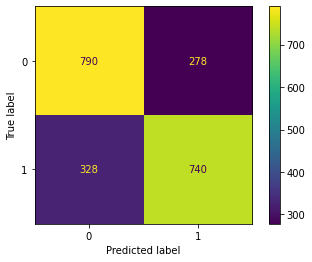

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1068
           1       0.73      0.69      0.71      1068

    accuracy                           0.72      2136
   macro avg       0.72      0.72      0.72      2136
weighted avg       0.72      0.72      0.72      2136

ROC_AUC_score: 0.7162921348314607
Accuracy: 0.7162921348314607
Precision_score: 0.7269155206286837
Recall_score: 0.6928838951310862


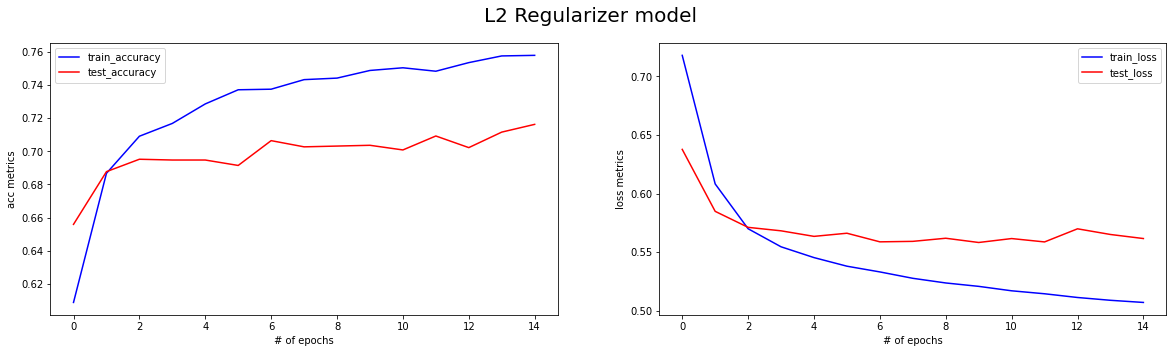

67/67 [==============================] - 0s 1ms/step - loss: 0.5615 - binary_accuracy: 0.7163


[0.5615339279174805, 0.716292142868042]

In [199]:
reg_model_history = model_training(reg_model,x_train,y_train,x_test,y_test)
plot(reg_model,reg_model_history,'L2 Regularizer model','binary_accuracy')

#### Dropout layer model

In [200]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(11, activation='relu', input_shape=(34,)))
drop_model.add(layers.Dropout(0.01))
drop_model.add(layers.Dense(4, activation='relu'))
drop_model.add(layers.Dropout(0.01))
drop_model.add(layers.Dense(1, activation='sigmoid'))
drop_model._name = 'Dropout_layers_model'
drop_model.summary()

Model: "Dropout_layers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 11)                385       
                                                                 
 dropout_1 (Dropout)         (None, 11)                0         
                                                                 
 dense_16 (Dense)            (None, 4)                 48        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 5         
                                                                 
Total params: 438
Trainable params: 438
Non-trainable params: 0
_________________________________________________________________


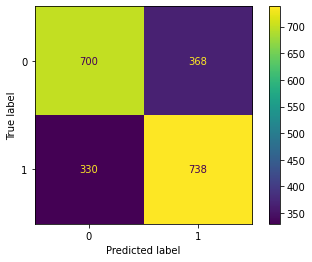

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1068
           1       0.67      0.69      0.68      1068

    accuracy                           0.67      2136
   macro avg       0.67      0.67      0.67      2136
weighted avg       0.67      0.67      0.67      2136

ROC_AUC_score: 0.6732209737827716
Accuracy: 0.6732209737827716
Precision_score: 0.6672694394213382
Recall_score: 0.6910112359550562


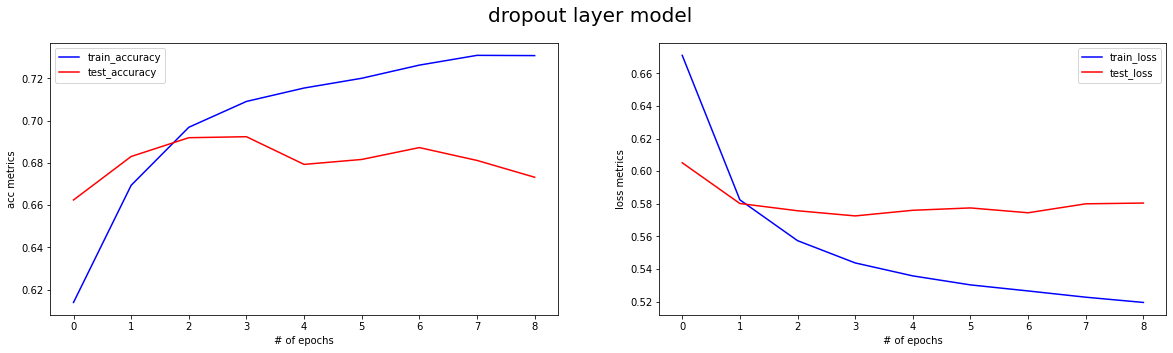

67/67 [==============================] - 0s 976us/step - loss: 0.5805 - binary_accuracy: 0.6732


[0.58045893907547, 0.6732209920883179]

In [201]:
drop_model_history = model_training(drop_model,x_train,y_train,x_test,y_test)
plot(drop_model,drop_model_history,'dropout layer model','binary_accuracy')

#### Combined all model

In [202]:
combine_model = models.Sequential()
combine_model.add(layers.Dense(11,activation = 'relu', input_shape = (34,),kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.01))
combine_model.add(layers.Dense(8,activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.01))
combine_model.add(layers.Dense(1,activation = 'sigmoid'))
combine_model._name = 'Combined_model'
combine_model.summary()

Model: "Combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 11)                385       
                                                                 
 dropout_3 (Dropout)         (None, 11)                0         
                                                                 
 dense_19 (Dense)            (None, 8)                 96        
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 490
Trainable params: 490
Non-trainable params: 0
_________________________________________________________________


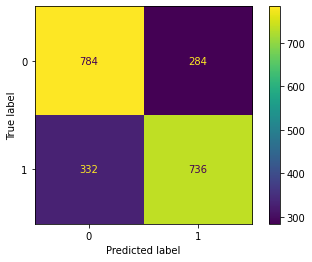

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1068
           1       0.72      0.69      0.70      1068

    accuracy                           0.71      2136
   macro avg       0.71      0.71      0.71      2136
weighted avg       0.71      0.71      0.71      2136

ROC_AUC_score: 0.7116104868913857
Accuracy: 0.7116104868913857
Precision_score: 0.7215686274509804
Recall_score: 0.6891385767790262


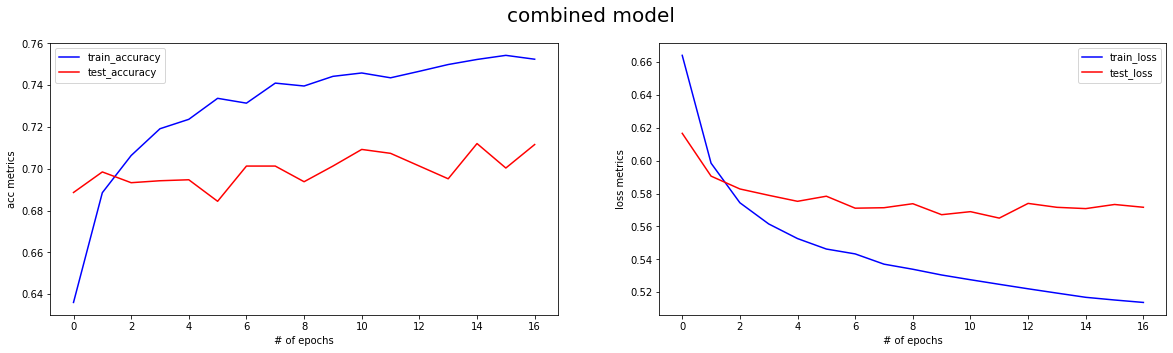

67/67 [==============================] - 0s 963us/step - loss: 0.5717 - binary_accuracy: 0.7116


[0.5716982483863831, 0.7116104960441589]

In [203]:
combine_model_history = model_training(combine_model,x_train,y_train,x_test,y_test)
plot(combine_model,combine_model_history,'combined model','binary_accuracy')

### Keras tuner model

In [204]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=5,
    overwrite=True,
    directory="my_dir",
    project_name="imb 1, Epochs = 100",
    
)

In [205]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input nuerons (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 5, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': None}


In [206]:
tuner.search(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test),callbacks =[tf.keras.callbacks.EarlyStopping(patience=5)] )

Trial 10 Complete [00h 00m 33s]
val_accuracy: 0.6935393333435058

Best val_accuracy So Far: 0.7014044880867004
Total elapsed time: 00h 04m 11s


In [207]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values.items()

dict_items([('input nuerons', 26), ('activation', 'relu'), ('num_layers', 1), ('units_0', 61), ('dropout', True), ('lr', 0.02914653536678597), ('units_1', 91)])

In [208]:
tuner_model = tuner.hypermodel.build(best_hps)
tuner_history = tuner_model.fit(x_train, y_train, epochs=epochs, validation_split=0.2,verbose=0,callbacks=callback)
tuner_model._name = 'Keras_tuner_model'
val_acc_per_epoch = tuner_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 15


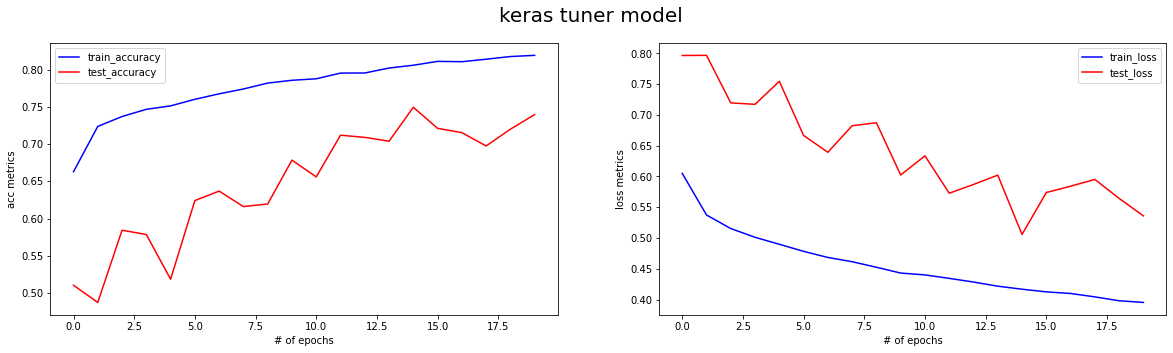

67/67 [==============================] - 0s 934us/step - loss: 0.6683 - accuracy: 0.6447


[0.6682710647583008, 0.6446629166603088]

In [209]:
plot(tuner_model,tuner_history,'keras tuner model',metric = 'accuracy')

# Summary

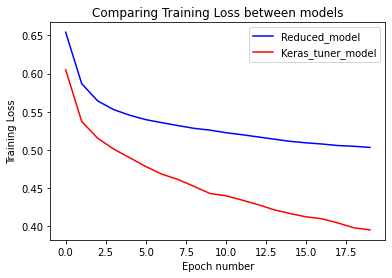

In [210]:
compare_models_by_metric(reduced_model,tuner_model,reduced_model_history,tuner_history,'loss')

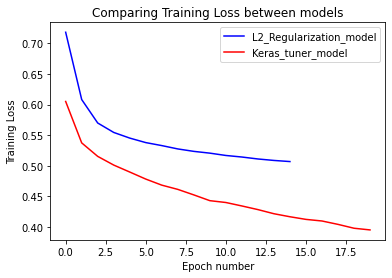

In [211]:
compare_models_by_metric(reg_model,tuner_model,reg_model_history,tuner_history,'loss')

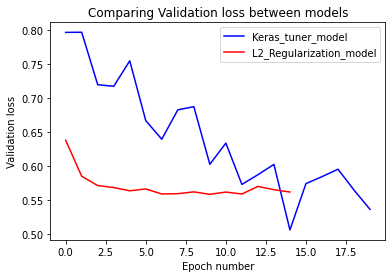

In [212]:
compare_models_by_metric(tuner_model,reg_model,tuner_history,reg_model_history,'val_loss')

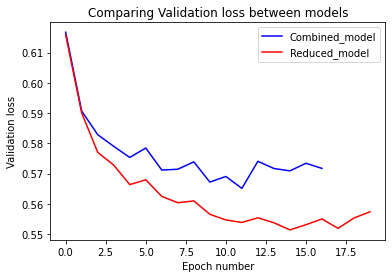

In [215]:
compare_models_by_metric(combine_model,reduced_model,combine_model_history,reduced_model_history,'val_loss')

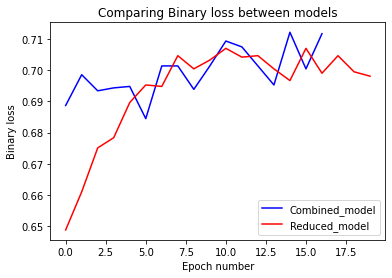

In [220]:
compare_models_by_metric(combine_model,reduced_model,combine_model_history,reduced_model_history,'val_binary_accuracy')

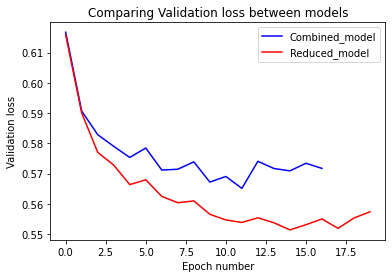

In [221]:
compare_models_by_metric(combine_model,reduced_model,combine_model_history,reduced_model_history,'val_loss')

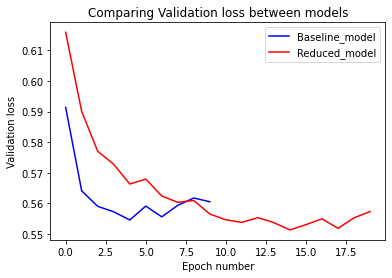

In [223]:
compare_models_by_metric(base_model,reduced_model,base_model_history,reduced_model_history,'val_loss')

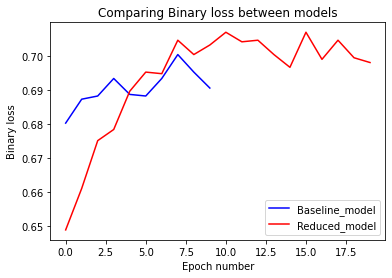

In [224]:
compare_models_by_metric(base_model,reduced_model,base_model_history,reduced_model_history,'val_binary_accuracy')